In [34]:
%load_ext autoreload
%autoreload 2
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d


from deepfly.CameraNetwork import CameraNetwork
from deepfly.Config import config_fly as config
from deepfly.os_util import *
from deepfly.plot_util import normalize_pose_3d
from deepfly.signal_util import *

plt.style.use('dark_background')
skeleton = config["skeleton"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading 3D points

In [35]:
image_folder = '/mnt/NAS/CLC/190409_SS30303-tdTomGC6fopt/Fly1/CO2xzGG/behData_004/images/'
calib = read_calib("../data/test/")

cid2cidread, cidread2cid = read_camera_order(image_folder)
camNet = CameraNetwork(image_folder=image_folder, cam_id_list=range(7), calibration=calib, cid2cidread=cid2cidread, num_images=100)
cam_list = camNet.cam_list
camNetLeft = CameraNetwork(image_folder=image_folder, cam_id_list=[0,1,2], cam_list=cam_list[:3], calibration=calib, cid2cidread=cid2cidread, num_images=100)
camNetRight = CameraNetwork(image_folder=image_folder, cam_id_list=[4,5,6], cam_list=cam_list[4:7] ,calibration=calib, cid2cidread=cid2cidread, num_images=100)

d = pickle.load(open(glob.glob(os.path.join(image_folder, 'pose_result*.pkl'))[0], 'rb'))

camNetList = [camNetLeft, camNetRight, camNet]
for cn in camNetList:
    for cam in cn:
        cam.points2d = d["points2d"][cam.cam_id, :]
for cn in camNetList[:-1]:
    cn.triangulate()
    cn.bundle_adjust()
    camNet.triangulate() 

Loading predictions ['/mnt/NAS/CLC/190409_SS30303-tdTomGC6fopt/Fly1/CO2xzGG/behData_004/images/preds_-mnt-NAS-CLC-190409_SS30303-tdTomGC6fopt-Fly1-CO2xzGG-behData_004-images.pkl']
Loading heatmaps ['/mnt/NAS/CLC/190409_SS30303-tdTomGC6fopt/Fly1/CO2xzGG/behData_004/images/heatmap_-mnt-NAS-CLC-190409_SS30303-tdTomGC6fopt-Fly1-CO2xzGG-behData_004-images.pkl']
Heatmap shape: (8, 100, 19, 64, 128)
Ignore_list [0, 1, 5, 6, 10, 11, 15, 19, 20, 24, 25, 29, 30, 34]:  10.4953
Replaced 0 points
Number of points:  1200
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9632e+05                                    4.41e+06    
       1              2         4.4437e+04      5.52e+05       6.79e+00       2.05e+05    
       2              3         3.9772e+04      4.67e+03       1.55e+00       1.31e+04    
       3              4         3.9759e+04      1.30e+01       7.30e-02       1.65e+02    
       4              5         

# Loading Template Points

In [36]:
image_folder = '../data/test/'
calib = read_calib("../data/test/")

cid2cidread, cidread2cid = read_camera_order(image_folder)
camNet_gt = CameraNetwork(image_folder=image_folder, cam_id_list=np.arange(config["num_cameras"]), calibration=calib, cid2cidread=cid2cidread, num_images=100)
# loading final results
d = pickle.load(open(glob.glob(os.path.join(image_folder, 'pose_result*.pkl'))[0], 'rb'))
for cam in camNet_gt.cam_list:
    cam.points2d = d["points2d"][cam.cam_id, :]
camNet_gt.triangulate()
camNet_gt.points3d_m = normalize_pose_3d(camNet_gt.points3d_m, rotate=False)

Loading predictions ['../data/test/preds_-home-user-Desktop-DeepFly3D-data-test.pkl']
Loading heatmaps ['../data/test/heatmap_-home-user-Desktop-DeepFly3D-data-test.pkl']
Heatmap shape: (8, 15, 19, 64, 128)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

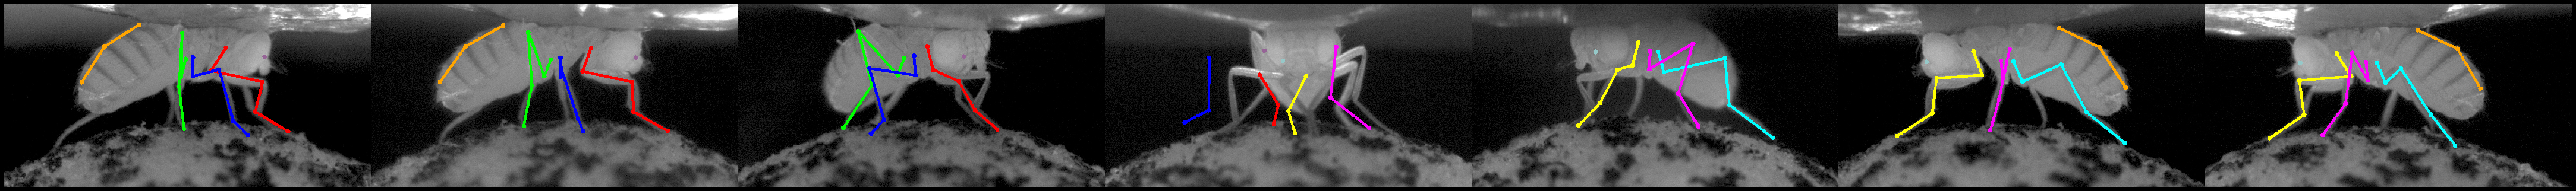

In [37]:
img_id = 5
camera_id_list = [0,1,2,3,4,5,6]
fig, ax_list = plt.subplots(1,len(camera_id_list),figsize=(60,60))
draw_joints = range(skeleton.num_joints)
for cam_id, ax in zip(camera_id_list, ax_list):
    pt = camNet.points3d_m[img_id,:,:]
    pts2d = camNet.cam_list[cam_id].project(pt)
    
    zorder = skeleton.get_zorder(camNet.cam_list[cam_id].cam_id)
    thickness = [5]*skeleton.num_limbs
    colors_tmp = skeleton.colors.copy()
    for l in range(skeleton.num_limbs):
        if not skeleton.camera_see_limb(camNet.cam_list[cam_id].cam_id, l):
            thickness[l] = 5
            colors_tmp[l] = (125,125,125)
    ax.imshow(camNet.cam_list[cam_id].plot_2d(img_id=img_id, pts=pts2d, colors=colors_tmp, thickness=thickness, draw_joints=None, zorder=zorder))
    ax.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

In [38]:
from drosophbehav.notebook.Procestus.Procrustes import procrustes, apply_transformation

m_left = np.arange(0,15)
points3d_gt_left = camNet_gt.points3d_m[:,m_left].copy()
points3d_pred_left = camNet.points3d_m[:,m_left].copy()
pts_t_left, tform = procrustes(pts=points3d_pred_left, template=points3d_gt_left, scaling=False, joint=[skeleton.Tracked.BODY_COXA, skeleton.Tracked.COXA_FEMUR], reflection='best', return_transf=True)
for cam in camNet.cam_list:
    if cam.cam_id < 3:
        cam.set_R(np.dot(cam.R, tform["rotation"]))
        cam.set_tvec(cam.tvec - np.dot(cam.R, tform["translation"]))
print(tform)
        
m_right = np.arange(19,19+15)
points3d_gt_right = camNet_gt.points3d_m[:,m_right].copy()
points3d_pred_right = camNet.points3d_m[:,m_right].copy()
pts_t_right, tform = procrustes(pts=points3d_pred_right, template=points3d_gt_right, scaling=False, joint=[skeleton.Tracked.BODY_COXA, skeleton.Tracked.COXA_FEMUR], reflection='best', return_transf=True)
for cam in camNet.cam_list:
    if cam.cam_id > 3:
        cam.set_R(np.dot(cam.R, tform["rotation"]))
        cam.set_tvec(cam.tvec - np.dot(cam.R, tform["translation"]))
print(tform)

pts3d_proc = np.zeros_like(camNet.points3d_m)
pts3d_proc[:,m_left] = pts_t_left.copy()
pts3d_proc[:,m_right] = pts_t_right.copy()

{'rotation': array([[ 0.99335396, -0.0142991 , -0.1142079 ],
       [-0.01613586,  0.96515376, -0.26118548],
       [ 0.1139629 ,  0.26129247,  0.95850858]]), 'scale': 1, 'translation': array([0.35437287, 2.35754745, 0.51494025])}
{'rotation': array([[ 0.99799479, -0.02653298,  0.05746652],
       [ 0.03282773,  0.99321951, -0.11152282],
       [-0.05411783,  0.11318569,  0.99209892]]), 'scale': 1, 'translation': array([0.01222483, 2.13011378, 1.00665733])}


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

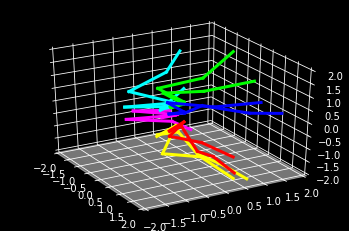

In [32]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from deepfly.plot_util import plot_drosophila_3d


def plt_3d(img_id):
    fig = plt.figure()
    #fig.canvas.layout.width = '500px'
    ax3d = fig.add_subplot(111, projection='3d')        
    draw_joints = [j for j in range(skeleton.num_joints) if skeleton.is_tracked_point(j,skeleton.Tracked.BODY_COXA) or skeleton.is_tracked_point(j,skeleton.Tracked.COXA_FEMUR) or skeleton.is_tracked_point(j,skeleton.Tracked.FEMUR_TIBIA) or skeleton.is_tracked_point(j,skeleton.Tracked.TIBIA_TARSUS)or skeleton.is_tracked_point(j,skeleton.Tracked.TARSUS_TIP)]
    
    lim=2
    plot_drosophila_3d(ax3d, pts3d_proc[img_id].copy(), 1, draw_joints=draw_joints, lim=lim)#, colors=[(0,0,255)]*100)
    plot_drosophila_3d(ax3d, camNet_gt.points3d_m[img_id].copy(), 1, draw_joints=draw_joints, lim=lim) #colors=[(0,255,0)]*100)
    #plot_drosophila_3d(ax3d, normalize_pose_3d(camNet.points3d_m.copy(), rotate=True)[img_id,:], 1, draw_joints=draw_joints)#colors=[(255,0,0)]*100)
        
plt_3d(0)

In [15]:
camNet.points3d_m[0][np.newaxis, :].copy().shape

(1, 38, 3)

In [16]:
%matplotlib inline
from ipywidgets import interactive
interactive_plot = interactive(plt_3d, img_id=(0,14))
output = interactive_plot.children[-1]
output.layout.height = '1000px'
interactive_plot

interactive(children=(IntSlider(value=7, description='img_id', max=14), Output(layout=Layout(height='1000px'))…

# 2D Pose Visualization

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

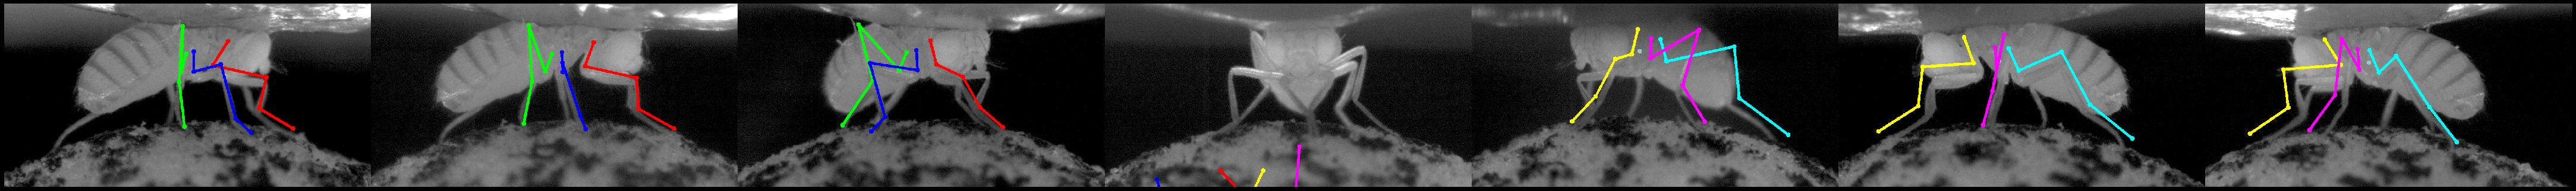

In [33]:
img_id = 5
'''
fig, ax_list = plt.subplots(1, len(camera_id_list),figsize=(60,60))
for idx in range(len(ax_list)):
    ax_list[idx].axis('off')
    ax_list[idx] = ax_list[idx].imshow(np.zeros((480,960,3)))
for cam_id, ax in zip(camera_id_list, ax_list):
    pts = camNet.cam_list[cam_id].points2d[img_id, :].copy()
    zorder = skeleton.get_zorder(cam_id)
    ax.set_data(camNet.cam_list[cam_id].plot_2d(img_id=img_id, pts=pts,
                                       zorder=zorder))
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
#plt.savefig(os.path.join(output_folder,f'pose2d_{img_id}.png'), bbox_inches = 'tight',
#    pad_inches = 0)

fig, ax_list = plt.subplots(1,len(camera_id_list),figsize=(60,60))
for cam_id, ax in zip(camera_id_list, ax_list):
    draw_joints = [j for j in range(skeleton.num_joints) if skeleton.camera_see_joint(cam_id, j)]
    img = camNet.cam_list[cam_id].get_image(img_id)

    ax.imshow(camNet.cam_list[cam_id].plot_heatmap(img_id, img=img, draw_joints=draw_joints))
    ax.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

#plt.savefig(os.path.join(output_folder, f"heatmap_{img_id}.png"), bbox_inches = 'tight',
#    pad_inches = 0)
'''

camNet = camNet
camera_id_list = [0,1,2,3,4,5,6]
fig, ax_list = plt.subplots(1,len(camera_id_list),figsize=(60,60))
draw_joints = range(skeleton.num_joints)
for cam_id, ax in zip(camera_id_list, ax_list):
    pt = pts3d_proc[img_id,:,:]
    pts2d = camNet.cam_list[cam_id].project(pt)

    zorder = skeleton.get_zorder(camNet.cam_list[cam_id].cam_id)
    thickness = [5]*skeleton.num_limbs
    colors_tmp = skeleton.colors.copy()
    for l in range(skeleton.num_limbs):
        if not skeleton.camera_see_limb(camNet.cam_list[cam_id].cam_id, l):
            thickness[l] = 5
            colors_tmp[l] = (125,125,125)
    ax.imshow(camNet.cam_list[cam_id].plot_2d(img_id=img_id, pts=pts2d, colors=colors_tmp, thickness=thickness, draw_joints=None, zorder=zorder))
    ax.axis('off')
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# 3D Visualization

0


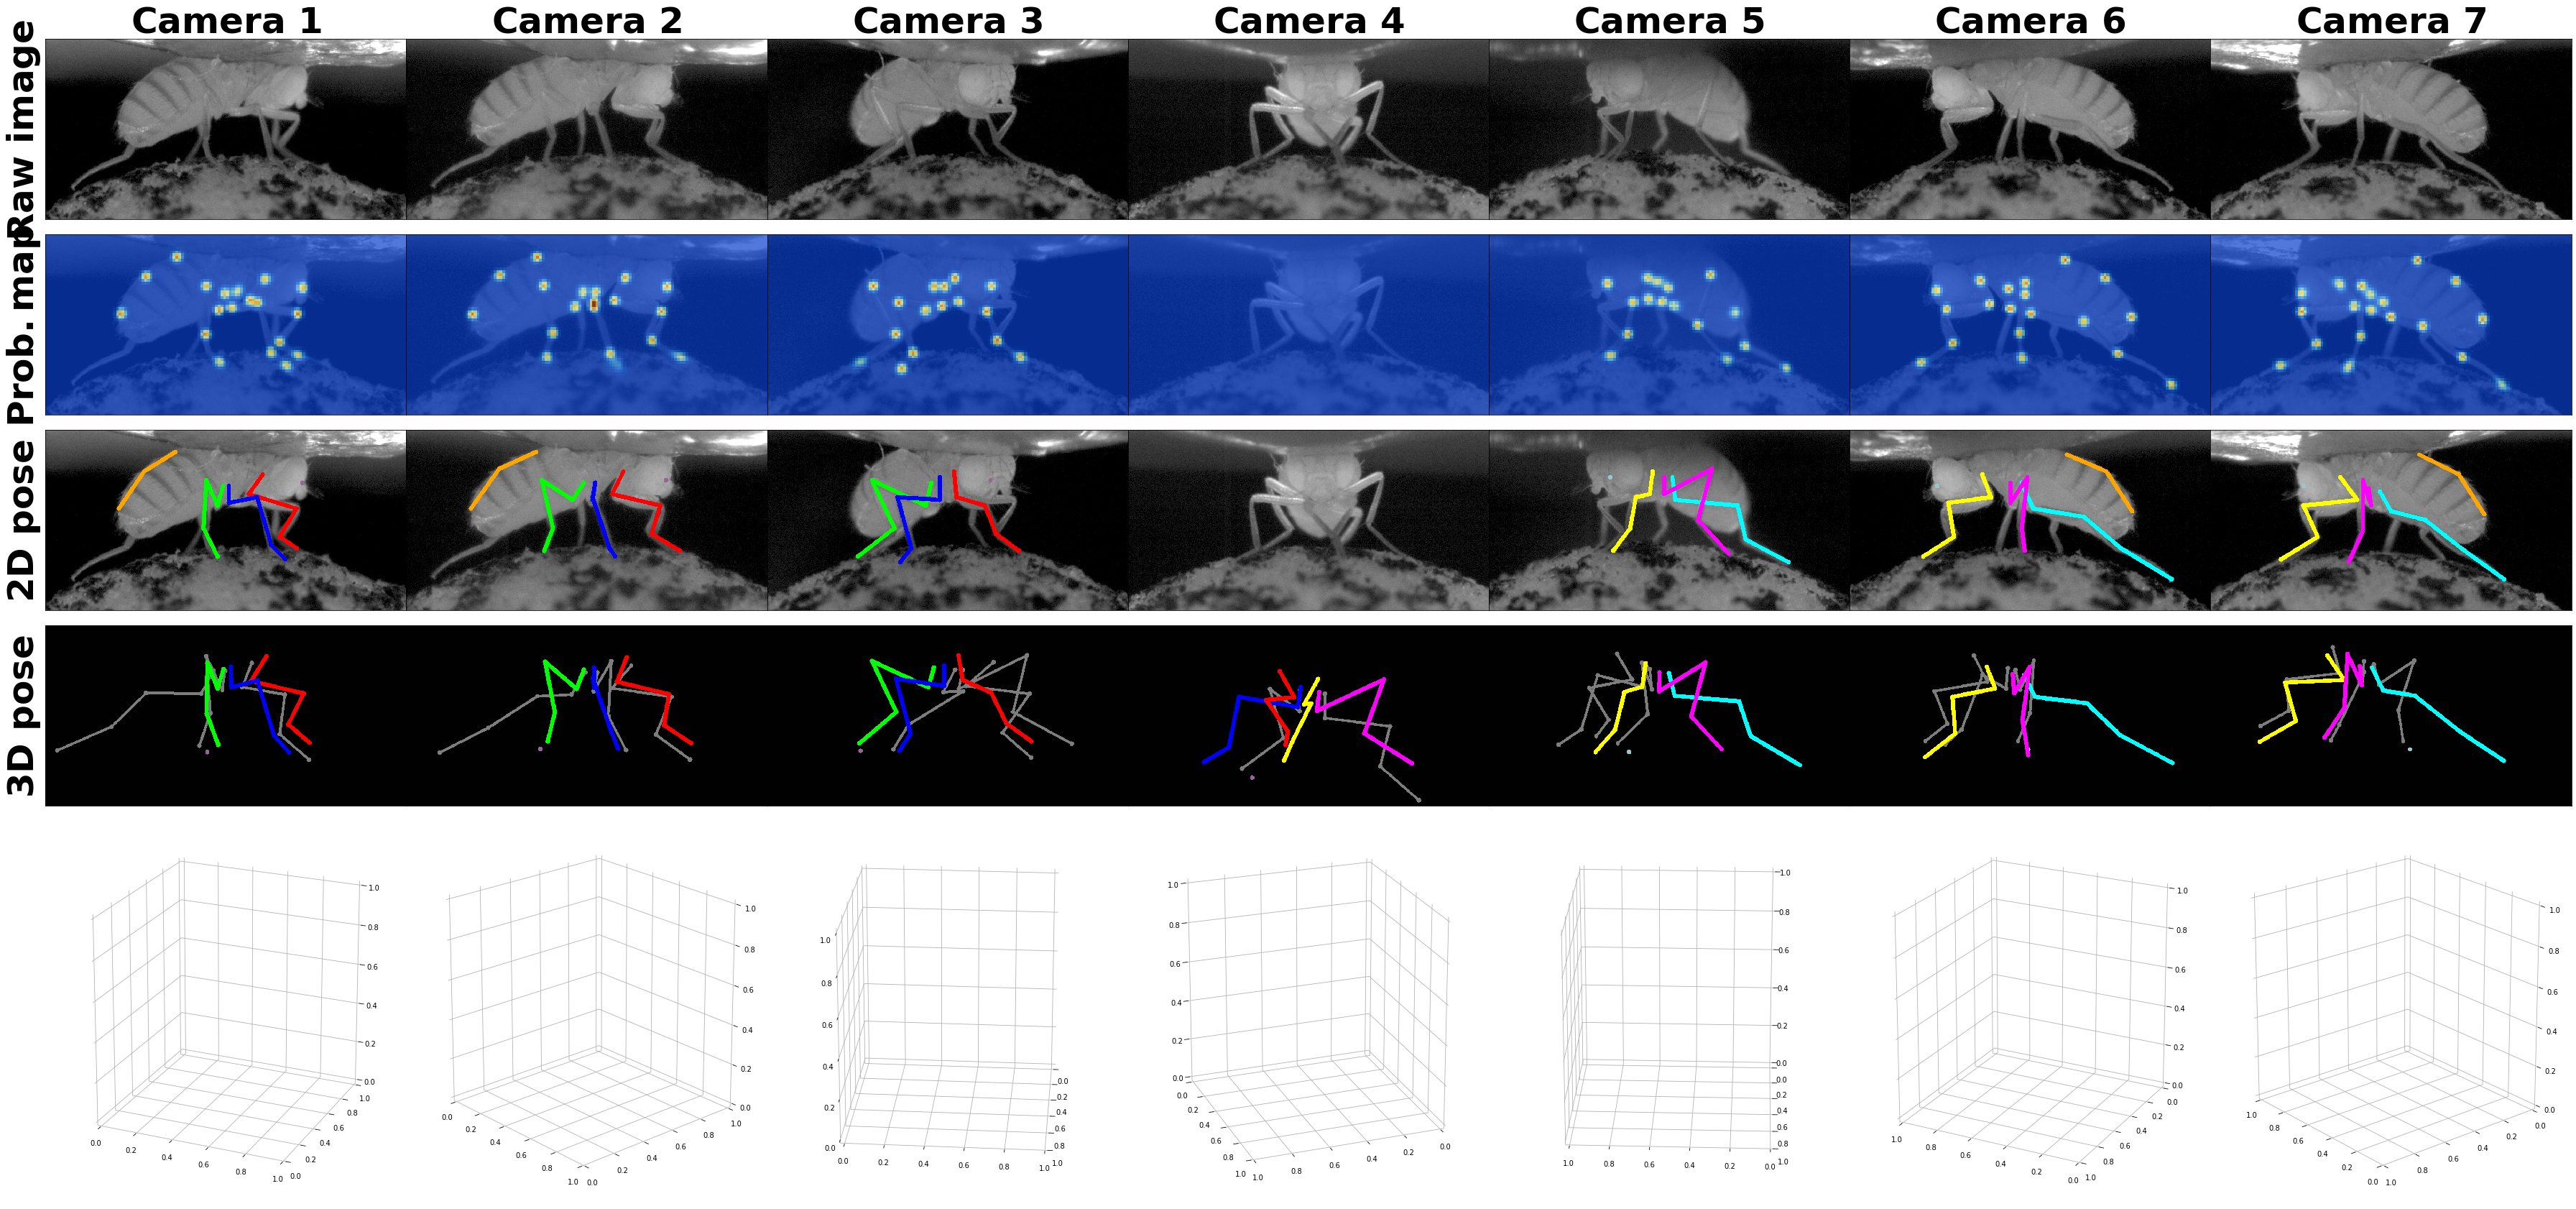

In [24]:
plt.style.use('default')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from deepfly.plot_util import plot_drosophila_3d
from deepfly.plot_util import normalize_pose_3d

fontsize = 50
num_rows, num_cols = 6, 7
fig = plt.figure(figsize=(num_cols*9,num_rows*5))

gs1 = gridspec.GridSpec(num_rows, num_cols)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

plt_list = []

pts_t = pts3d_filter.copy()
tmp = pts_t[:,:,1].copy()
pts_t[:,:,1] = pts_t[:,:,2].copy()
pts_t[:,:,2] = tmp
pts_t[:,:,2] *=-1 
pts_t[:,:,1] *=-1 

pts_t = normalize_pose_3d(pts_t, normalize_median=True)
title_list = ["Camera\ {}".format(i) for i in range(1,8)]
ylabel_list = ["Raw\ image", "Prob. map", "2D\ pose", r"Projected 3D pose", "3D\ pose"]
for i in range(num_rows*num_cols):
    r = int(i / num_cols)
    c = i % num_cols
    if r==4:
        ax1 = plt.subplot(gs1[r:, c] , projection='3d')
        ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    elif r<4:
        ax1 = plt.subplot(gs1[r,c])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_aspect('equal')
        #plt.axis('off')
        
    if r==0:
        ax1.set_title( r"$\bf{" + title_list[c] + "}$", fontsize=fontsize, fontname="Times New Roman Bold")
    if c==0 and r==3: 
        ax1.set_ylabel(r"$\bf{3D\ pose}$", fontsize=fontsize)
    if c==0 and r!=3 and r!=4 and r!=5:
        ax1.set_ylabel(r"$\bf{" + ylabel_list[r] + "}$", fontsize=fontsize)
    if c==0 and r==4:
        pass
        
    if r==4:
        plt_list.append(ax1)
    elif r<4:
        plt_list.append(ax1.imshow(np.zeros((480,960,3), dtype=np.uint8)))
        if c==num_cols-1 and r==0:
            pass

img_id_list = np.arange(0, 10)
for img_id in img_id_list:
    if img_id%50==0:
        print(img_id)
    for r in range(num_rows):
        for c in range(num_cols):
            img = camNet.cam_list[c].get_image(img_id)
            zorder = skeleton.get_zorder(c)
            draw_joints = [j for j in range(skeleton.num_joints) if skeleton.camera_see_joint(c, j)]
            i = r*num_cols + c
            if r == 0: # raw
                plt_list[i].set_data(img)
            elif r==1: # heatmap
                plt_list[i].set_data(camNet.cam_list[c].plot_heatmap(img_id, img=img, flip_heatmap=False, draw_joints=draw_joints))
            elif r==2: # 2d pose
                draw_limbs = None
                plt_list[i].set_data(camNet.cam_list[c].plot_2d(img_id, img=img, flip_points=False, draw_limbs=draw_limbs, zorder=zorder, thickness=[10]*skeleton.num_limbs))
            elif r==3: # projection of 3d pose
                draw_joints = range(skeleton.num_joints)
                pt = pts3d_filter[img_id,:,:]
                for j in range(skeleton.num_joints):
                    if skeleton.is_tracked_point(j, skeleton.Tracked.STRIPE) and skeleton.is_joint_visible_left(j):
                        pt[j] = (pt[j] + pt[j+(skeleton.num_joints // 2)]) / 2
                        pt[j + skeleton.num_joints // 2] = pt[j]
                pts2d = camNet.cam_list[c].project(pt)
                
                thickness = [10]*skeleton.num_limbs
                colors_tmp = skeleton.colors.copy()
                for l in range(skeleton.num_limbs):
                    if not skeleton.camera_see_limb(camNet.cam_list[c].cam_id, l):
                        thickness[l] = 5
                        colors_tmp[l] = (125,125,125)
                plt_list[i].set_data(camNet.cam_list[c].plot_2d(img=np.ones((480,960,3), dtype=np.uint8), img_id=img_id, pts=pts2d, flip_points=False, colors=colors_tmp, thickness=thickness, draw_joints=draw_joints, zorder=zorder))
            elif r==4: # 3d pose
                ax_3d = plt_list[i]
                points3d = pts_t[img_id,:,:]
                
                ang = -90 - (camNet.cam_list[c].rvec[1]*57.2)
                period = 180.0 # frames
                extend = -20
                # rotate cameras 
                ang_move = np.sin(2*np.pi*((img_id)/period))*extend
                ang += ang_move
                
                ax_3d.elev = 20
                draw_joints = [j for j in range(skeleton.num_joints) if (skeleton.is_tracked_point(j, skeleton.Tracked.COXA_FEMUR) or skeleton.is_tracked_point(j, skeleton.Tracked.FEMUR_TIBIA) or skeleton.is_tracked_point(j, skeleton.Tracked.TIBIA_TARSUS) or skeleton.is_tracked_point(j, skeleton.Tracked.TARSUS_TIP))]
                
                colors_tmp = skeleton.colors.copy()
                thickness = [config["line_thickness"]]*skeleton.num_limbs
                                        
                plot_drosophila_3d(ax_3d=ax_3d, points3d=points3d, cam_id=c, ang=ang, draw_joints=draw_joints, zorder=zorder, colors=colors_tmp, thickness=thickness, lim=2)
    
    #plt.savefig(os.path.join(output_folder, f'row5_{img_id}.png'), bbox_inches = 'tight',
    #  pad_inches = 0)
    for c in range(num_cols):
        if num_rows >= 4:
            r = 4
            i = r*num_cols + c
            ax_3d = plt_list[i]
            ax_3d.cla()    